In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

import gc
gc.enable()
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

# Preprocessing & Feature Engineering

In [2]:
#from IPython.display import display as ipydisplay, HTML
#ipydisplay(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 80em; }</style>"))

In [3]:
SEED = 42
n_splits = 5

In [4]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [5]:
train = pd.read_csv(path + 'train.csv', dtype={'id': str})
test = pd.read_csv(path + 'test.csv', dtype={'id': str})
#sample = pd.read_csv(path + 'sample_submission.csv', dtype={'id': str})

In [6]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')

In [7]:
train_target = train[test.columns]

In [8]:
concat_df = pd.concat([train_target, test], ignore_index=True)

In [9]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [10]:
del train_target
gc.collect()

0

In [11]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]

In [12]:
for col in concat_df.columns:
    if col == 'id':
        continue
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [13]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')

In [14]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)

del instrument_df, field_list
gc.collect()

0

In [15]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')

In [16]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]

In [17]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')

In [18]:
test_parquet_id_list = [v.replace('id=', '') for v in test_parquet_id_folders_list]

In [19]:
train_temp_df = concat_df.head(train.shape[0]).reset_index(drop=True)

In [20]:
test_temp_df = concat_df.tail(test.shape[0]).reset_index(drop=True)

In [21]:
del concat_df
gc.collect()

0

In [22]:
train_temp_df['has_parquet'] = train_temp_df['id'].isin(train_parquet_id_list).astype(int)

In [23]:
test_temp_df['has_parquet'] = test_temp_df['id'].isin(test_parquet_id_list).astype(int)

In [24]:
# https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda
entropy = lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()

In [25]:
def feat_engi(df, target_cols):
    stats_df = df[target_cols].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99]).T
    count = stats_df['count'][0]
    stats_df.drop('count', axis=1, inplace=True)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    reshaped_df['count'] = count

    return reshaped_df

In [26]:
def groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    return reshaped_df

In [27]:
def uncommon_groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe()
        #df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)

    
    #stats_stats_df = stats_df.describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    stats_stats_df = stats_df.describe()
    stats_stats_count = stats_stats_df['count'][0]
    stats_stats_df.drop('count', axis=0, inplace=True)
    stats_stats_df = stats_stats_df.T
    
    column_names_list = []
    for idx in stats_stats_df.index:
        for col in stats_stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))
    
    reshaped_df = pd.DataFrame(stats_stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    current_cols = reshaped_df.columns.tolist()
    count_col_name = target_col + '_' + col_to_group + '_count'
    reshaped_df[count_col_name] = stats_stats_count

    reshaped_df = reshaped_df[[count_col_name] + current_cols]

    return reshaped_df

In [28]:
def read_parquet(dataset='train'):
    parquet_id_folders_list = os.listdir(path + 'series_' + dataset + '.parquet/')
    ts_list = []
    ts_features_list = []
    for id_folder in tqdm(parquet_id_folders_list):
        iid = id_folder.replace('id=', '')
    
        parquet_files_path = path + 'series_' + dataset + '.parquet/' + id_folder + '/'
        parquet_files_list = os.listdir(parquet_files_path)
    
        dfs_list = []
        for parquet_filename in parquet_files_list:
            if '.parquet' in parquet_filename:
                parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
                dfs_list.append(parquet_df)
        parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
        current_cols = parquet_concat_df.columns.tolist()
        
        parquet_concat_df['id'] = iid
        
        parquet_concat_df = parquet_concat_df[['id'] + current_cols]
        
        parquet_concat_df['day_since_wear'] = (parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()).astype(int)
        parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
        parquet_concat_df.drop('time_of_day', axis=1, inplace=True)
        parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day_sec'] / 60
        parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day_min'] / 60
        parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day_hour'] / 24
        parquet_concat_df['time_of_day_hour_window'] = parquet_concat_df['time_of_day_hour'].astype(int)
        parquet_concat_df['time_of_day_min_window'] = parquet_concat_df['time_of_day_min'].astype(int)
        parquet_concat_df['time_of_day_15_min_window'] = (parquet_concat_df['time_of_day_min'] / 15).astype(int)
        parquet_concat_df['timestamp_day'] = parquet_concat_df['day_since_wear'] + parquet_concat_df['time_of_day_day']
    
        if parquet_concat_df['timestamp_day'].nunique() != parquet_concat_df.shape[0]:
            print('yes')
    
        parquet_concat_df['timestamp_hour'] = parquet_concat_df['timestamp_day'] * 24
        parquet_concat_df['timestamp_min'] = parquet_concat_df['timestamp_day'] * 24 * 60
        parquet_concat_df['timestamp_sec'] = parquet_concat_df['timestamp_day'] * 24 * 60 * 60
        parquet_concat_df['timestamp_15_min'] = parquet_concat_df['timestamp_day'] * 24 * (60/15)
    
        parquet_concat_df['timestamp_hour_window'] = parquet_concat_df['timestamp_hour'].astype(int)
        parquet_concat_df['timestamp_min_window'] = parquet_concat_df['timestamp_min'].astype(int)
        parquet_concat_df['timestamp_15_min_window'] = parquet_concat_df['timestamp_15_min'].astype(int)
    
        battery_voltage_start = parquet_concat_df['battery_voltage'][0]
        parquet_concat_df['battery_use_since_wear'] = -(parquet_concat_df['battery_voltage'] - battery_voltage_start)
        
    
        worn_df = parquet_concat_df[parquet_concat_df['non-wear_flag'] == 0].reset_index(drop=True)
    
        
        feature_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_use_since_wear']
    
        features_df = feat_engi(worn_df, feature_cols)
    
        groupby_cols = ['weekday', 'time_of_day_hour_window']#, 'time_of_day_15_min_window']
    
        groupby_df_list = []
        for groupby_col in groupby_cols:
            for feature_col in feature_cols:
                groupby_features_df = groupby_feat_engi(worn_df, groupby_col, feature_col)
                groupby_df_list.append(groupby_features_df)
    
        groupby_concat_df = pd.concat(groupby_df_list, axis=1)
    
        uncommon_groupby_cols = ['day_since_wear', 'timestamp_hour_window']#, 'timestamp_15_min_window']#, 'timestamp_min_window']
    
        uncommon_groupby_df_list = []
        for uncommon_groupby_col in uncommon_groupby_cols:
            for unc_feature_col in feature_cols:
                uncommon_groupby_df = uncommon_groupby_feat_engi(worn_df, uncommon_groupby_col, unc_feature_col)
                uncommon_groupby_df_list.append(uncommon_groupby_df)
    
        features_concat_df = pd.concat([features_df, groupby_concat_df, uncommon_groupby_df], axis=1)
        features_current_cols = features_concat_df.columns.tolist()
        features_concat_df['id'] = iid
        features_concat_df = features_concat_df[['id'] + features_current_cols]
    
        for q in [1,2,3,4]:
            if q in worn_df['quarter'].tolist():
                features_concat_df['data_collected_in_quarter_' + str(q)] = 1
            else:
                features_concat_df['data_collected_in_quarter_' + str(q)] = 0

        features_concat_df['id'] = features_concat_df['id'].astype(str)

        #features_concat_df.to_csv(path + 'series_' + dataset + '.parquet/id=' + iid + '/features.csv', index=False)
        
        ts_list.append(parquet_concat_df)
        ts_features_list.append(features_concat_df)

        gc.collect()
    gc.collect()
    
    return ts_list, ts_features_list

In [29]:
def read_features_files():
    temp_dfs_list = []
    ts_features_folders_list = os.listdir(path + 'train_ts_features/')
    for temp_id_folder in tqdm(ts_features_folders_list):
        temp_files_list = os.listdir(path + 'train_ts_features/' + temp_id_folder + '/')
        for temp_filename in temp_files_list:
            if '.csv' in temp_filename:
                temp_df = pd.read_csv(path + 'train_ts_features/' + temp_id_folder + '/' + temp_filename, dtype={'id': str})
                temp_dfs_list.append(temp_df)
    gc.collect()
    return temp_dfs_list

In [30]:
train_ts_features_list = read_features_files()

100%|████████████████████████████████████████████████████████████████████████████████| 996/996 [04:47<00:00,  3.47it/s]


In [31]:
test_ts_list, test_ts_features_list = read_parquet(dataset='test')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


In [32]:
train_ts_features_concat_df = pd.concat(train_ts_features_list, ignore_index=True)
test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)

In [33]:
del train_ts_features_list, test_ts_features_list
gc.collect()

0

In [34]:
train_merge_df = train_temp_df.merge(train_ts_features_concat_df, how='left', on='id')
test_merge_df = test_temp_df.merge(test_ts_features_concat_df, how='left', on='id')

In [35]:
del train_ts_features_concat_df, test_ts_features_concat_df
gc.collect()

0

In [36]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [37]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]

In [38]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
cat_cols = [col for col in cat_cols if 'PCIAT' not in col]

In [39]:
merge_concat_df = pd.concat([train_merge_df, test_merge_df], ignore_index=True)

In [40]:
del train_merge_df, test_merge_df
gc.collect()

0

In [41]:
def remove_pciat_cols(df):
    cols_to_drop = []
    for col in df.columns:
        if 'PCIAT' in col:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [42]:
merge_concat_df = remove_pciat_cols(merge_concat_df)

In [43]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [44]:
merge_concat_df = one_hot_cat_cols(merge_concat_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 303.12it/s]


In [45]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [46]:
merge_concat_df = feature_engineering(merge_concat_df)

In [47]:
no_id_cols = [col for col in merge_concat_df.columns if col != 'id']

In [48]:
if np.any(np.isinf(merge_concat_df[no_id_cols])):
    print('inf in data')
    merge_concat_df[no_id_cols] = merge_concat_df[no_id_cols].replace([np.inf, -np.inf], np.nan)

inf in data


In [49]:
imputer = KNNImputer(n_neighbors=5)
merge_concat_df[no_id_cols] = imputer.fit_transform(merge_concat_df[no_id_cols])

In [50]:
del imputer
gc.collect()

0

In [51]:
train_df = merge_concat_df.head(train.shape[0]).reset_index(drop=True)
test_df = merge_concat_df.tail(test.shape[0]).reset_index(drop=True)

In [52]:
train_df['sii'] = train['sii']

In [53]:
del train, test
gc.collect()

0

In [54]:
train_nonan_df = train_df[~train_df['sii'].isna()].reset_index(drop=True)

In [55]:
del train_df
gc.collect()

0

In [56]:
#selected_features_df = pd.read_csv(path + 'selected_features.csv')

In [57]:
#train_cols = selected_features_df['selected_features'].tolist()

In [58]:
#del selected_features_df
#gc.collect()

In [59]:
#test_cols = train_cols.copy()
#test_cols.remove('sii')

In [60]:
#train_final_df = train_nonan_df[train_cols].copy()
#test_final_df = test_df[test_cols].copy()

In [61]:
train_final_df = train_nonan_df.copy()
test_final_df = test_df.copy()

In [62]:
del train_nonan_df, test_df
gc.collect()

0

In [63]:
corr_df = train_final_df.drop(['id', 'sii'], axis=1).corr()

In [64]:
# Find features with high correlation
high_corr = np.where(corr_df > 0.9)
high_corr_pairs = [
    (corr_df.index[x], corr_df.columns[y])
    for x, y in zip(*high_corr)
    if x != y and x < y
]

In [65]:
second_v_list = []
for v in high_corr_pairs:
    second_v = v[1]
    second_v_list.append(second_v)

In [66]:
redundant_features = list(set(second_v_list))

In [67]:
train_final_df = train_final_df.drop(redundant_features, axis=1)
print(train_final_df.shape)
train_final_df.head()

(2736, 1420)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          25.0                   78.8   
1             46.0                          22.0                   75.0   
2             75.6                          27.0                   65.0   
3             81.6                          26.4                   60.0   
4            112.2                          32.0                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.0                 130.2                          4.4   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          5.8                        39.4        12.0   

   FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
0              0.0         20.50                1.8        21.18   
1              0.0         23.08                2.0        24.94   
2              1.0         10.20                1.0        14.70   
3              1.0         17.66                2.0        19.24   
4              0.0         16.50                2.0        17.90   

   FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
0               1.8         0.0              0.0          7.0   
1               2.0         5.0              0.0         11.0   
2               2.0         7.0              1.0         10.0   
3               2.0         5.0              0.0          7.0   
4               2.0         6.0              0.0         10.0   

   FGC-FGC_SRL_Zone  FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone  \
0               0.0               0.0         6.0              1.0   
1               1.0               1.0         3.0              0.0   
2               1.0               1.0         5.0              0.0   
3               0.0               0.0         7.0              1.0   
4               1.0               1.0         8.0              0.0   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_FFMI  \
0                         2.0     2.668550     16.87920      13.81770   
1                         2.0     2.579490     14.03710      12.82540   
2                         2.4     4.310264     18.29524      24.52766   
3                         3.0     3.841910     18.29430      14.07400   
4                         2.0     4.330360     30.18650      16.68770   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  PAQ_A-PAQ_A_Total  \
0      3.06143     9.213770                1.0              1.844   
1      1.21172     3.970850                1.0              1.704   
2     -6.23241   -24.811978                1.4              2.578   
3      4.22033    18.824300                2.0              2.018   
4     13.49880    67.971500                2.0              2.004   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             

In [68]:
test_final_df = test_final_df.drop(redundant_features, axis=1)
print(test_final_df.shape)
test_final_df.head()

(20, 1419)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          25.0                   78.8   
1             46.0                          22.0                   75.0   
2             75.6                          27.0                   65.0   
3             81.6                          26.4                   60.0   
4             20.0                          31.7                   66.4   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.0                 130.2                          4.4   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                75.4                 113.6                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          7.2                        17.8         5.8   

   FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
0              0.0         20.50                1.8        21.18   
1              0.0         23.08                2.0        24.94   
2              1.0         10.20                1.0        14.70   
3              1.0         17.66                2.0        19.24   
4              0.8         28.28                2.2        27.96   

   FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
0               1.8         0.0              0.0          7.0   
1               2.0         5.0              0.0         11.0   
2               2.0         7.0              1.0         10.0   
3               2.0         5.0              0.0          7.0   
4               2.0         4.2              0.4         12.5   

   FGC-FGC_SRL_Zone  FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone  \
0               0.0               0.0         6.0              1.0   
1               1.0               1.0         3.0              0.0   
2               1.0               1.0         5.0              0.0   
3               0.0               0.0         7.0              1.0   
4               1.0               1.0         8.6              0.8   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_FFMI  \
0                         2.0     2.668550     16.87920      13.81770   
1                         2.0     2.579490     14.03710      12.82540   
2                         2.4     4.310264     18.29524      24.52766   
3                         3.0     3.841910     18.29430      14.07400   
4                         3.0     5.477302     20.24658      15.81610   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  PAQ_A-PAQ_A_Total  \
0     3.061430     9.213770                1.0              1.844   
1     1.211720     3.970850                1.0              1.704   
2    -6.232410   -24.811978                1.4              2.578   
3     4.220330    18.824300                2.0              2.018   
4     4.430456    26.554596                2.4              1.040   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             

In [69]:
selected_cols_df = pd.read_csv(path + 'selected_cols.csv')
selected_cols_df

col
0                                                       id
1                                          Basic_Demos-Age
2                                          CGAS-CGAS_Score
3                                             Physical-BMI
4                                          Physical-Height
5                             Physical-Waist_Circumference
6                                       Physical-HeartRate
7                                     Physical-Systolic_BP
8                                               FGC-FGC_CU
9                                             FGC-FGC_GSND
10                                             FGC-FGC_GSD
11                                              FGC-FGC_PU
12                                             FGC-FGC_SRL
13                                              FGC-FGC_TL
14                                             BIA-BIA_BMC
15                                            BIA-BIA_FFMI
16                                       PAQ_C-PAQ_C_Total
17                                       SDS-SDS_Total_Raw
18                  PreInt_EduHx-computerinternet_hoursday
19                      Physical-Waist_Circumference_isnan
20                                                enmo_std
21                                              anglez_max
22                                                light_1%
23                                         X_weekday_3_min
24                                        X_weekday_4_mean
25                                         X_weekday_6_max
26                                          Y_weekday_7_1%
27                                     Y_weekday_7_entropy
28                                         Z_weekday_1_min
29                                          Z_weekday_2_1%
30                                         Z_weekday_2_90%
31                                         Z_weekday_3_std
32                                         Z_weekday_4_25%
33                                         Z_weekday_5_std
34                                        Z_weekday_6_mean
35                                         Z_weekday_6_std
36                                     enmo_weekday_3_mean
37                                      enmo_weekday_3_std
38                                      enmo_weekday_6_max
39                                anglez_weekday_3_entropy
40                                    light_weekday_4_mean
41                                     light_weekday_4_max
42                                 light_weekday_4_entropy
43                    battery_use_since_wear_weekday_2_30%
44                   battery_use_since_wear_weekday_3_mean
45                    battery_use_since_wear_weekday_3_30%
46                    battery_use_since_wear_weekday_3_35%
47                    battery_use_since_wear_weekday_4_min
48                    battery_use_since_wear_weekday_5_max
49                    battery_use_since_wear_weekday_6_max
50                    battery_use_since_wear_weekday_7_35%
51                         X_time_of_day_hour_window_1_min
52                         X_time_of_day_hour_window_1_sum
53                     X_time_of_day_hour_window_1_entropy
54                         X_time_of_day_hour_window_2_sum
55                         X_time_of_day_hour_window_3_sum
56                        X_time_of_day_hour_window_4_mean
57                        X_time_of_day_hour_window_5_mean
58                     X_time_of_day_hour_window_6_entropy
59                          X_time_of_day_hour_window_7_1%
60                    X_time_of_day_hour_window_10_entropy
61                        X_time_of_day_hour_window_15_max
62                        X_time_of_day_hour_window_20_min
63                        X_time_of_day_hour_window_22_max
64                        X_time_of_day_hour_window_22_sum
65                         Y_time_of_day_hour_window_0_sum
66                         Y_time_of_day_hour_window_2_std
67                     Y_time_of_day_hour_w

In [70]:
selected_cols = selected_cols_df['col'].tolist()

In [71]:
train_final_df = train_final_df[selected_cols + ['sii']]
print(train_final_df.shape)
train_final_df.head()

(2736, 146)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          32.0                73.0                 102.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18         0.0          7.0         6.0   
1         3.0         23.08        24.94         5.0         11.0         3.0   
2        20.0         10.20        14.70         7.0         10.0         5.0   
3        18.0         17.66        19.24         5.0          7.0         7.0   
4        12.0         16.50        17.90         6.0         10.0         8.0   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     4.330360      16.68770             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

   enmo_std  anglez_max  light_1%  X_weekday_3_min  X_weekday_4_mean  \
0  0.091819   89.296684  0.027718        -1.181594          0.029699   
1  0.120810   89.456932  0.036794        -1.175764          0.030971   
2  0.142927   89.528796  0.092944        -1.384442          0.013404   
3  0.106351   89.751656  0.000752        -0.973490         -0.213124   
4  0.040610   89.476036  0.023839        -1.015088          0.255062   

   X_weekday_6_max  Y_weekday_7_1%  Y_weekday_7_entropy  Z_weekday_1_min  \
0         1.078925       -0.851288            24.108867        -1.001339   
1         1.245570       -0.980870            20.828965        -1.000690   
2         1.400885       -0.978399            64.399943        -1.001535   
3         1.007214       -0.962770            42.000340        -1.013281   
4         1.005606       -0.877587            21.477032        -1.011558   

   Z_weekday_2_1%  Z_weekday_2_90%  Z_weekday_3_std  Z_weekday_4_25%  \
0       -0.972502         0.796212         0.544952        -0.227438   
1       -0.959960         0.861982         0.592790        -0.303603   
2       -0.987065         0.545133         0.548045        -0.517429   
3       -1.006329         0.717635         0.554800        -0.539505   
4       -1.011740         0.829801         0.635620        -0.643907   

   Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  enmo_weekday_3_mean  \
0         0.502684         -0.050002         0.546032             0.046002   
1         0.540959         -0.201450         0.483489             0.043606   
2         0.508000         -0.070163         0.535905             0.046373   
3         0.581047         -0.31607

In [72]:
test_final_df = test_final_df[selected_cols]
print(test_final_df.shape)
test_final_df.head()

(20, 145)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          31.7                75.4                 113.6   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18         0.0          7.0         6.0   
1         3.0         23.08        24.94         5.0         11.0         3.0   
2        20.0         10.20        14.70         7.0         10.0         5.0   
3        18.0         17.66        19.24         5.0          7.0         7.0   
4         5.8         28.28        27.96         4.2         12.5         8.6   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     5.477302      15.81610             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     2.2                                 1.0   

   enmo_std  anglez_max  light_1%  X_weekday_3_min  X_weekday_4_mean  \
0  0.091819   89.296684  0.027718        -1.181594          0.029699   
1  0.120810   89.456932  0.036794        -1.175764          0.030971   
2  0.142927   89.528796  0.092944        -1.384442          0.013404   
3  0.106351   89.751656  0.000752        -0.973490         -0.213124   
4  0.095470   88.557333  0.189376        -1.180735         -0.043651   

   X_weekday_6_max  Y_weekday_7_1%  Y_weekday_7_entropy  Z_weekday_1_min  \
0         1.078925       -0.851288            24.108867        -1.001339   
1         1.245570       -0.980870            20.828965        -1.000690   
2         1.400885       -0.978399            64.399943        -1.001535   
3         1.007214       -0.962770            42.000340        -1.013281   
4         0.682226       -0.716204            31.479834        -0.601322   

   Z_weekday_2_1%  Z_weekday_2_90%  Z_weekday_3_std  Z_weekday_4_25%  \
0       -0.972502         0.796212         0.544952        -0.227438   
1       -0.959960         0.861982         0.592790        -0.303603   
2       -0.987065         0.545133         0.548045        -0.517429   
3       -1.006329         0.717635         0.554800        -0.539505   
4       -0.956910         0.715061         0.555871        -0.748480   

   Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  enmo_weekday_3_mean  \
0         0.502684         -0.050002         0.546032             0.046002   
1         0.540959         -0.201450         0.483489             0.043606   
2         0.508000         -0.070163         0.535905             0.046373   
3         0.581047         -0.31607

# Parameter tuning, training, prediction & submission

In [73]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [74]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [83]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)

def lgb_feature_selection(train_data, test_data, optuna_n_trials):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'verbosity': -1,
        'seed': SEED,
        'num_iterations': 10000,
        'feature_fraction': 0.8,
        'device': 'gpu'
    }

    def objective(trial):

        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'early_stopping_round': trial.suggest_int('early_stopping_round', 10, 60),
            'max_depth': trial.suggest_int('max_depth', 6, 50),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 300),
            'num_leaves': trial.suggest_int('num_leaves', 50, 10000),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.3),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
            'lambda_l2': trial.suggest_float('lambda_l2', 50, 2000)
        }

        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
            
            lgb_callbacks = [
                lgb.log_evaluation(period=20)
            ]
    
            model = LGBMRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)
    
            #plt.figure()
            #lgb.plot_metric(model)
            #plt.show()
            
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

        # https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/551533
        y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
        oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."

        del y_preds_df, oof_initial_thresholds
        gc.collect()
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        #print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        return tKappa

    with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
        
        # Define a callback function to update the progress bar
        def progress_bar_callback(study, trial):
            pbar.update(1)
    
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    '''pbar = tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial")
        
    # Define a callback function to update the progress bar
    def progress_bar_callback(study, trial):
        pbar.update(1)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    pbar.close()'''

    best_params = study.best_params

    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **base_params,
            **best_params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_y_preds_df = pd.DataFrame({'y':y_train, 'preds':y_train_pred})
        train_oof_initial_thresholds = train_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=train_oof_initial_thresholds, args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_y_preds_df = pd.DataFrame({'y':y_val, 'preds':y_val_pred})
        val_oof_initial_thresholds = val_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=val_oof_initial_thresholds, args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
    oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm, study

Optimizing: 100%|███████████████████████████████████████████████████████████████| 300/300 [1:09:50<00:00, 13.97s/trial]


<Figure size 640x480 with 0 Axes>

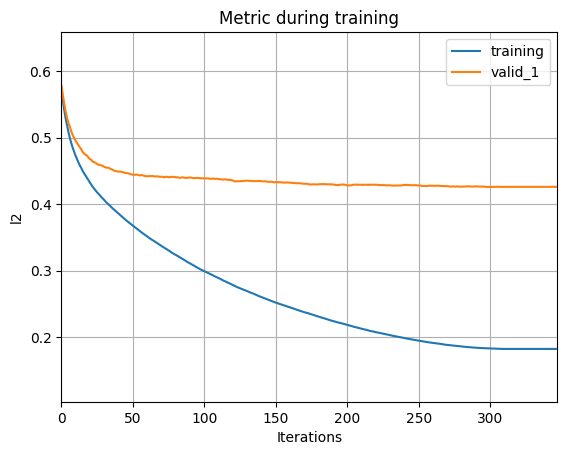

----> || Train Optimized QWK SCORE ::  0.852
----> || Val Optimized QWK SCORE ::  0.536
----> || Train Optimized Val QWK SCORE ::  0.503
----> || Val Optimized Train QWK SCORE ::  0.808
Fold 1 - Rounded Train QWK: 0.7596, Rounded Validation QWK: 0.4170


<Figure size 640x480 with 0 Axes>

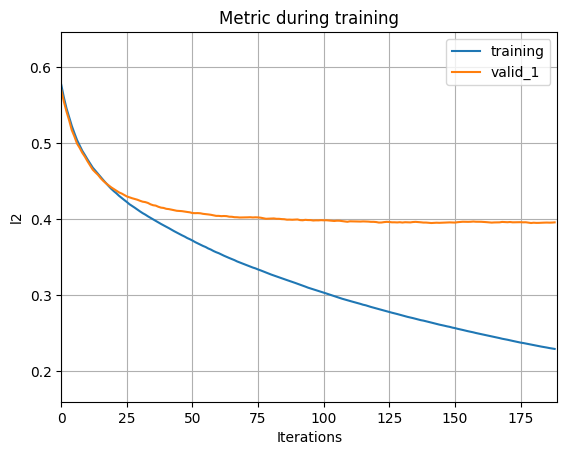

----> || Train Optimized QWK SCORE ::  0.755
----> || Val Optimized QWK SCORE ::  0.572
----> || Train Optimized Val QWK SCORE ::  0.508
----> || Val Optimized Train QWK SCORE ::  0.742
Fold 2 - Rounded Train QWK: 0.6471, Rounded Validation QWK: 0.4631


<Figure size 640x480 with 0 Axes>

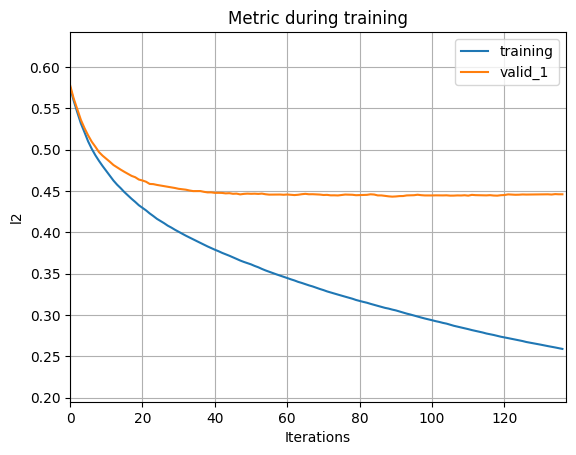

----> || Train Optimized QWK SCORE ::  0.710
----> || Val Optimized QWK SCORE ::  0.499
----> || Train Optimized Val QWK SCORE ::  0.463
----> || Val Optimized Train QWK SCORE ::  0.666
Fold 3 - Rounded Train QWK: 0.5863, Rounded Validation QWK: 0.3749


<Figure size 640x480 with 0 Axes>

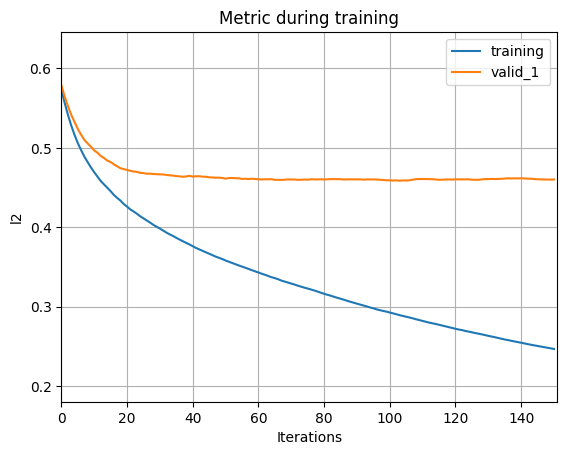

----> || Train Optimized QWK SCORE ::  0.729
----> || Val Optimized QWK SCORE ::  0.487
----> || Train Optimized Val QWK SCORE ::  0.441
----> || Val Optimized Train QWK SCORE ::  0.709
Fold 4 - Rounded Train QWK: 0.6175, Rounded Validation QWK: 0.3535


<Figure size 640x480 with 0 Axes>

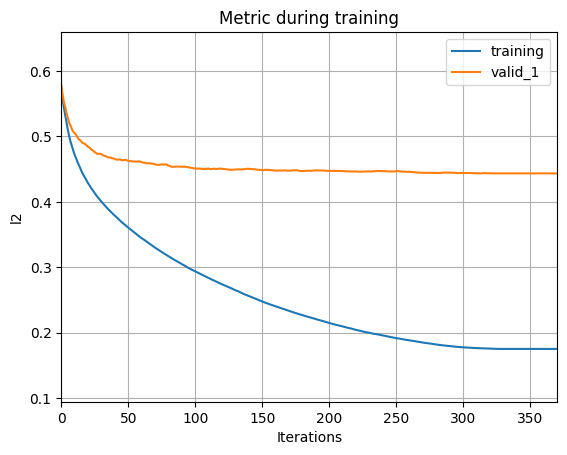

----> || Train Optimized QWK SCORE ::  0.852
----> || Val Optimized QWK SCORE ::  0.443
----> || Train Optimized Val QWK SCORE ::  0.461
----> || Val Optimized Train QWK SCORE ::  0.799
Fold 5 - Rounded Train QWK: 0.7847, Rounded Validation QWK: 0.4037
Mean Train QWK --> 0.7795
Mean Validation QWK ---> 0.5072
----> || Optimized QWK SCORE ::  0.509


In [76]:
lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(train_final_df, test_final_df, 300)

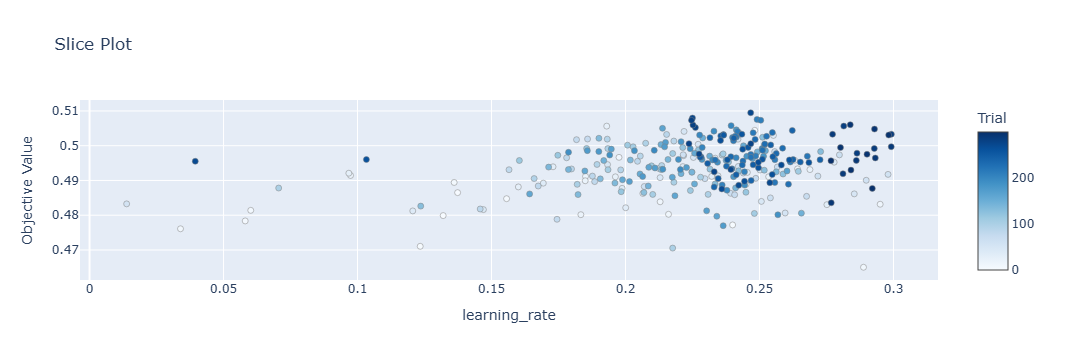

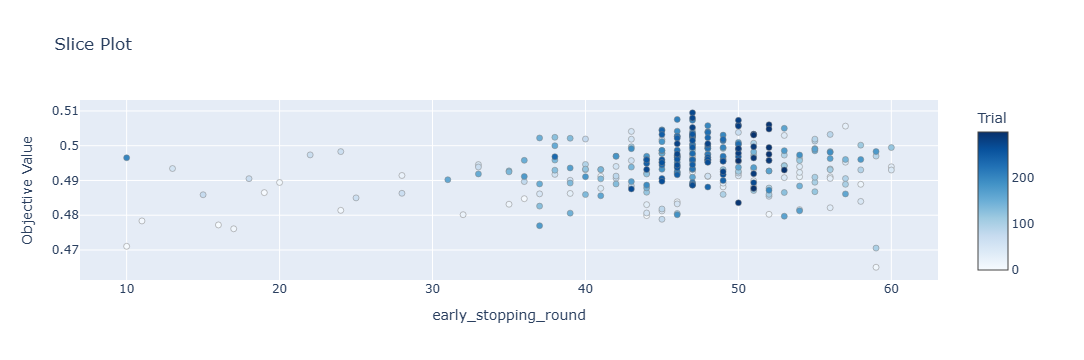

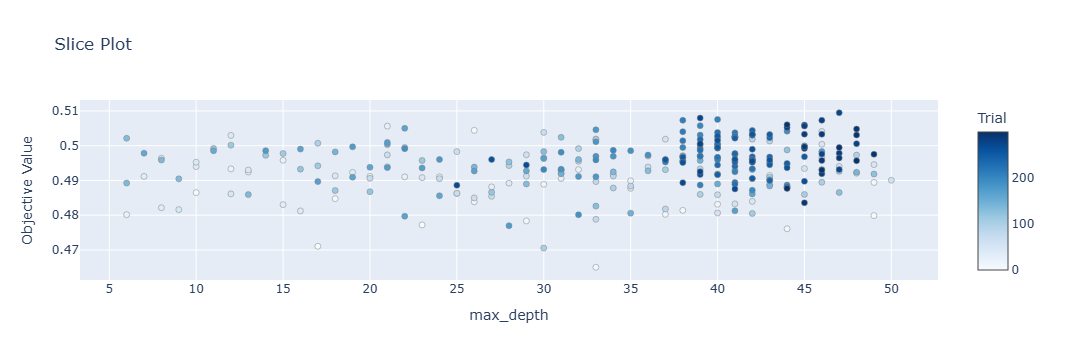

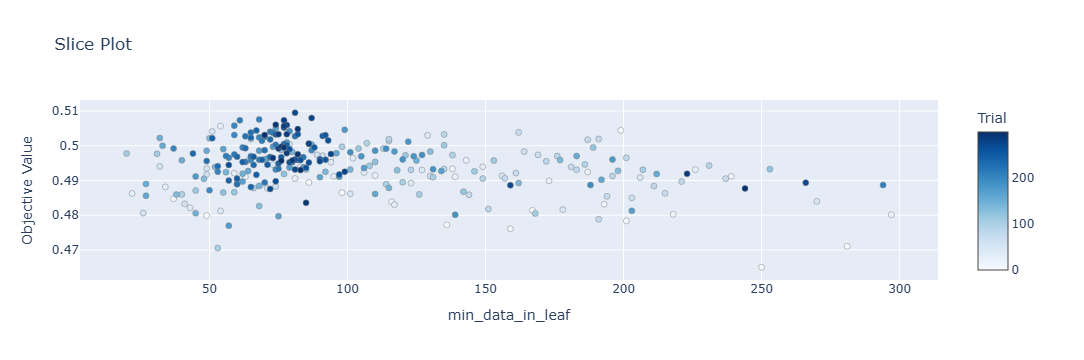

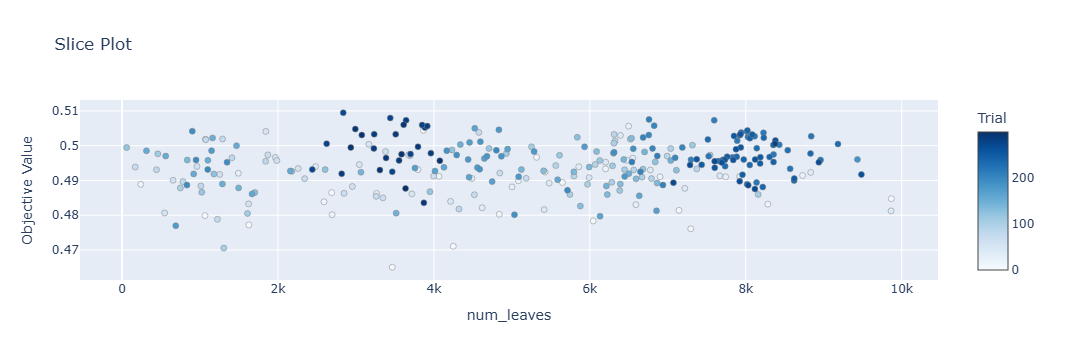

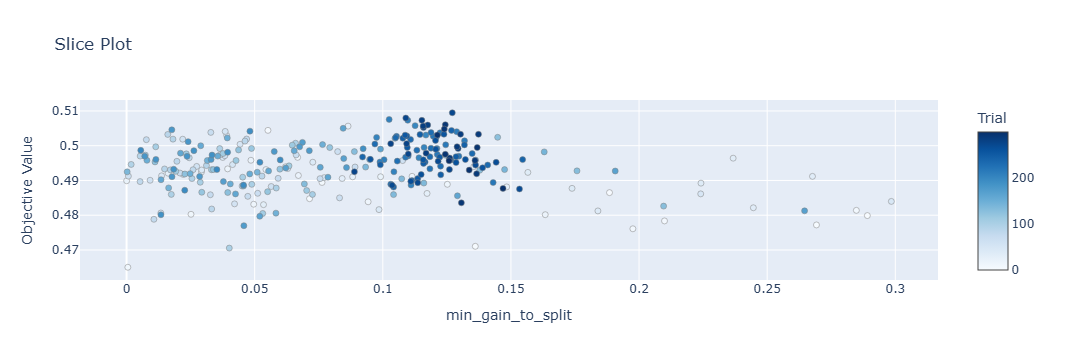

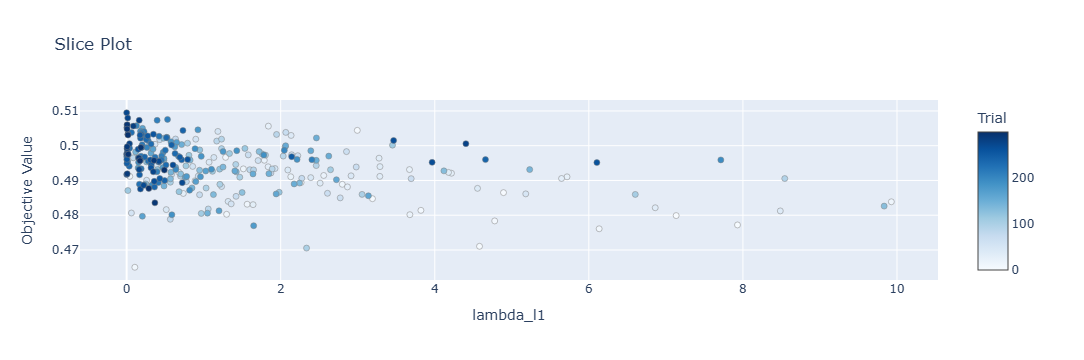

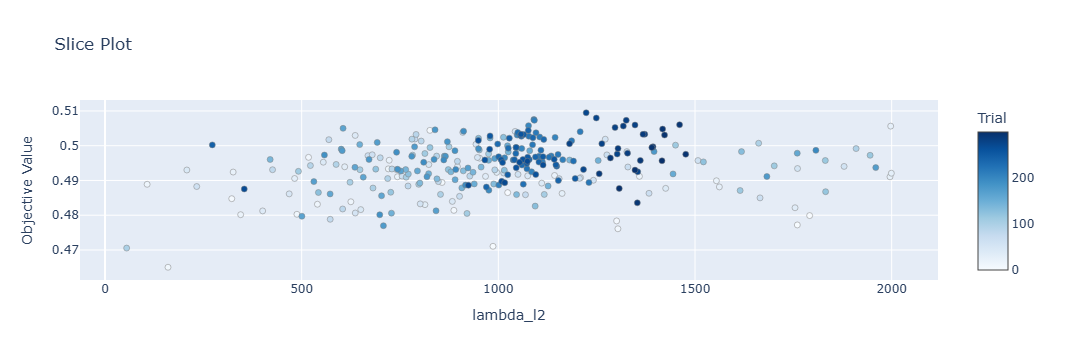

In [77]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

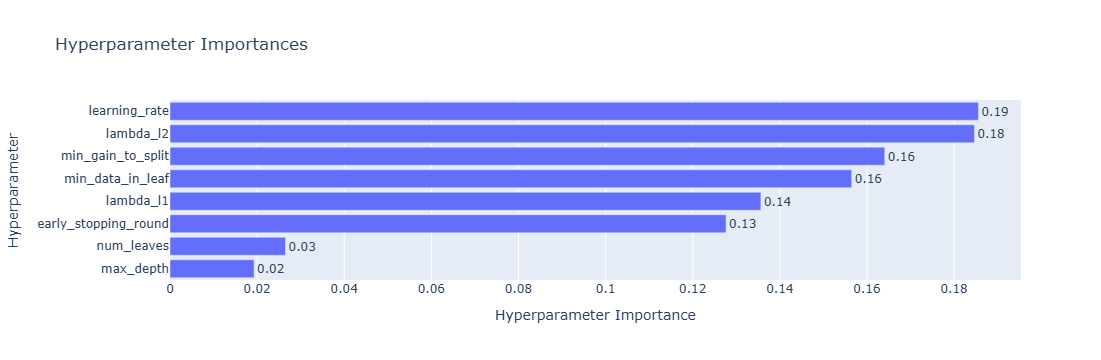

In [78]:
plot_param_importances(lgb_optuna_study)

In [79]:
lgb_optuna_study.best_params

{'learning_rate': 0.24669624005863247,
 'early_stopping_round': 47,
 'max_depth': 47,
 'min_data_in_leaf': 81,
 'num_leaves': 2837,
 'min_gain_to_split': 0.1271151752248657,
 'lambda_l1': 0.0005699582269810266,
 'lambda_l2': 1223.2746470842283}

In [80]:
cols = train_final_df.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [81]:
train_selected_df = train_final_df.drop(unimportant_cols, axis=1)
print(train_selected_df.shape)
train_selected_df.head()

(2736, 131)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          32.0                73.0                 102.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18         0.0          7.0         6.0   
1         3.0         23.08        24.94         5.0         11.0         3.0   
2        20.0         10.20        14.70         7.0         10.0         5.0   
3        18.0         17.66        19.24         5.0          7.0         7.0   
4        12.0         16.50        17.90         6.0         10.0         8.0   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     4.330360      16.68770             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

   enmo_std  anglez_max  X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  \
0  0.091819   89.296684        -1.181594          0.029699         1.078925   
1  0.120810   89.456932        -1.175764          0.030971         1.245570   
2  0.142927   89.528796        -1.384442          0.013404         1.400885   
3  0.106351   89.751656        -0.973490         -0.213124         1.007214   
4  0.040610   89.476036        -1.015088          0.255062         1.005606   

   Y_weekday_7_1%  Y_weekday_7_entropy  Z_weekday_1_min  Z_weekday_2_90%  \
0       -0.851288            24.108867        -1.001339         0.796212   
1       -0.980870            20.828965        -1.000690         0.861982   
2       -0.978399            64.399943        -1.001535         0.545133   
3       -0.962770            42.000340        -1.013281         0.717635   
4       -0.877587            21.477032        -1.011558         0.829801   

   Z_weekday_3_std  Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  \
0         0.544952         0.502684         -0.050002         0.546032   
1         0.592790         0.540959         -0.201450         0.483489   
2         0.548045         0.508000         -0.070163         0.535905   
3         0.554800         0.581047         -0.316070         0.644435   
4         0.635620         0.636366          0.148574         0.646251   

   enmo_weekday_3_mean  enmo_weekday_3_std  enmo_weekday_6_max  \
0             0.046002            0.088560            2.353769   
1             0.043606            0.110911            2.285202   
2             0.046373            0.123684            3.491380   
3             0.047503       

In [82]:
test_selected_df = test_final_df.drop(unimportant_cols, axis=1)
print(test_selected_df.shape)
test_selected_df.head()

(20, 130)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          31.7                75.4                 113.6   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18         0.0          7.0         6.0   
1         3.0         23.08        24.94         5.0         11.0         3.0   
2        20.0         10.20        14.70         7.0         10.0         5.0   
3        18.0         17.66        19.24         5.0          7.0         7.0   
4         5.8         28.28        27.96         4.2         12.5         8.6   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     5.477302      15.81610             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     2.2                                 1.0   

   enmo_std  anglez_max  X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  \
0  0.091819   89.296684        -1.181594          0.029699         1.078925   
1  0.120810   89.456932        -1.175764          0.030971         1.245570   
2  0.142927   89.528796        -1.384442          0.013404         1.400885   
3  0.106351   89.751656        -0.973490         -0.213124         1.007214   
4  0.095470   88.557333        -1.180735         -0.043651         0.682226   

   Y_weekday_7_1%  Y_weekday_7_entropy  Z_weekday_1_min  Z_weekday_2_90%  \
0       -0.851288            24.108867        -1.001339         0.796212   
1       -0.980870            20.828965        -1.000690         0.861982   
2       -0.978399            64.399943        -1.001535         0.545133   
3       -0.962770            42.000340        -1.013281         0.717635   
4       -0.716204            31.479834        -0.601322         0.715061   

   Z_weekday_3_std  Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  \
0         0.544952         0.502684         -0.050002         0.546032   
1         0.592790         0.540959         -0.201450         0.483489   
2         0.548045         0.508000         -0.070163         0.535905   
3         0.554800         0.581047         -0.316070         0.644435   
4         0.555871         0.363256         -0.016320         0.438409   

   enmo_weekday_3_mean  enmo_weekday_3_std  enmo_weekday_6_max  \
0             0.046002            0.088560            2.353769   
1             0.043606            0.110911            2.285202   
2             0.046373            0.123684            3.491380   
3             0.047503       

Optimizing: 100%|█████████████████████████████████████████████████████████████████| 300/300 [55:25<00:00, 11.09s/trial]


<Figure size 640x480 with 0 Axes>

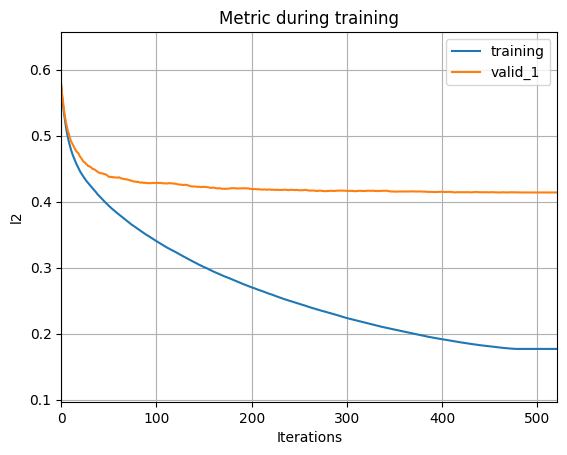

----> || Train Optimized QWK SCORE ::  0.846
----> || Val Optimized QWK SCORE ::  0.552
----> || Train Optimized Val QWK SCORE ::  0.505
----> || Val Optimized Train QWK SCORE ::  0.808
Fold 1 - Rounded Train QWK: 0.7708, Rounded Validation QWK: 0.4177


<Figure size 640x480 with 0 Axes>

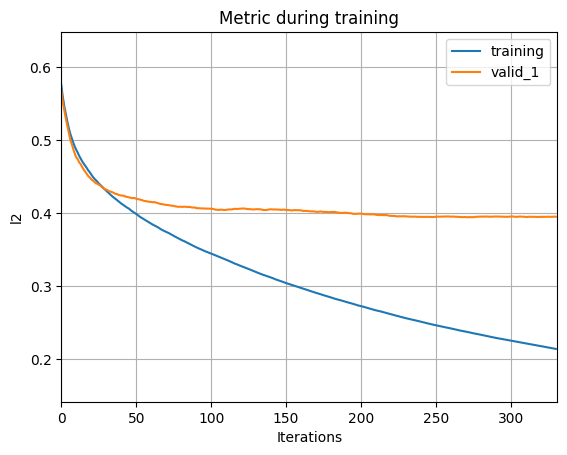

----> || Train Optimized QWK SCORE ::  0.797
----> || Val Optimized QWK SCORE ::  0.574
----> || Train Optimized Val QWK SCORE ::  0.540
----> || Val Optimized Train QWK SCORE ::  0.780
Fold 2 - Rounded Train QWK: 0.6953, Rounded Validation QWK: 0.5121


<Figure size 640x480 with 0 Axes>

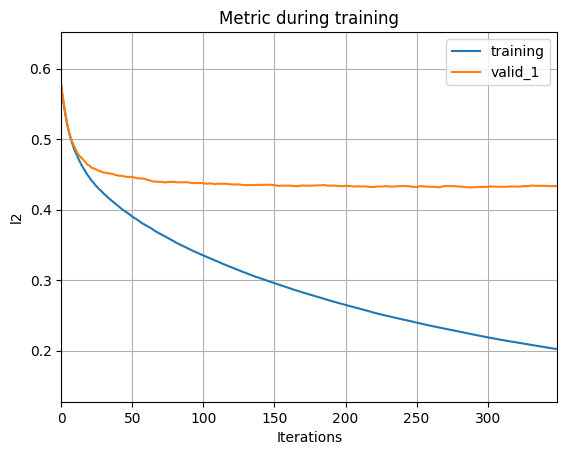

----> || Train Optimized QWK SCORE ::  0.800
----> || Val Optimized QWK SCORE ::  0.532
----> || Train Optimized Val QWK SCORE ::  0.506
----> || Val Optimized Train QWK SCORE ::  0.762
Fold 3 - Rounded Train QWK: 0.7000, Rounded Validation QWK: 0.4230


<Figure size 640x480 with 0 Axes>

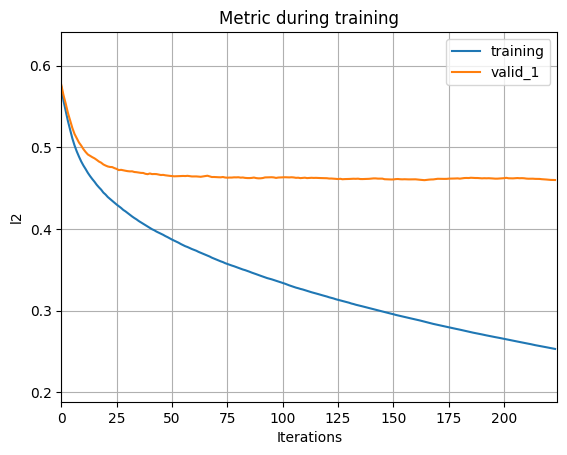

----> || Train Optimized QWK SCORE ::  0.727
----> || Val Optimized QWK SCORE ::  0.452
----> || Train Optimized Val QWK SCORE ::  0.465
----> || Val Optimized Train QWK SCORE ::  0.673
Fold 4 - Rounded Train QWK: 0.6293, Rounded Validation QWK: 0.3624


<Figure size 640x480 with 0 Axes>

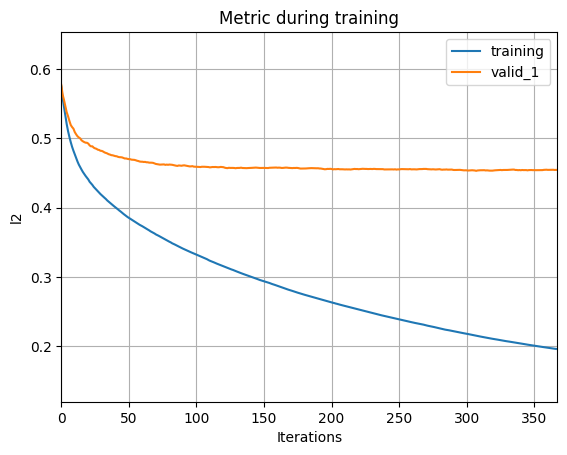

----> || Train Optimized QWK SCORE ::  0.808
----> || Val Optimized QWK SCORE ::  0.446
----> || Train Optimized Val QWK SCORE ::  0.420
----> || Val Optimized Train QWK SCORE ::  0.754
Fold 5 - Rounded Train QWK: 0.7169, Rounded Validation QWK: 0.3886
Mean Train QWK --> 0.7957
Mean Validation QWK ---> 0.5112
----> || Optimized QWK SCORE ::  0.514


In [84]:
lgb_models_list2, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df, test_selected_df, 300
)

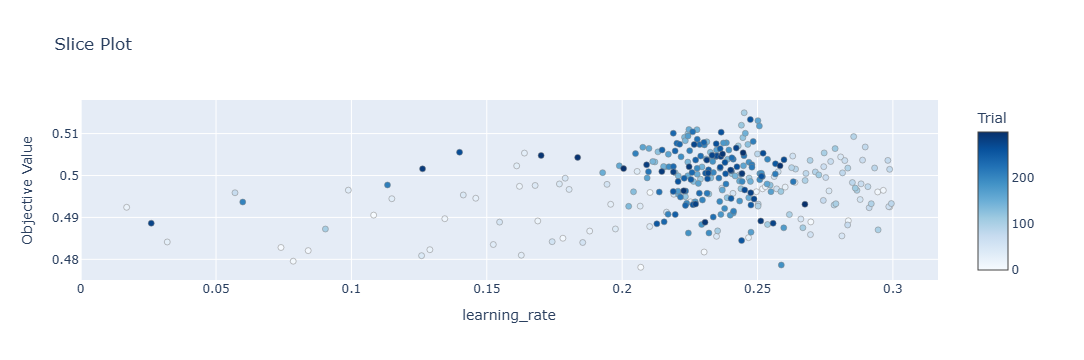

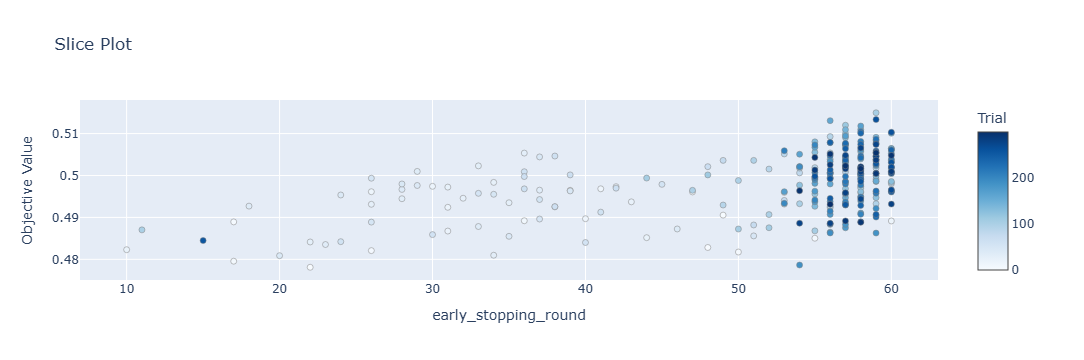

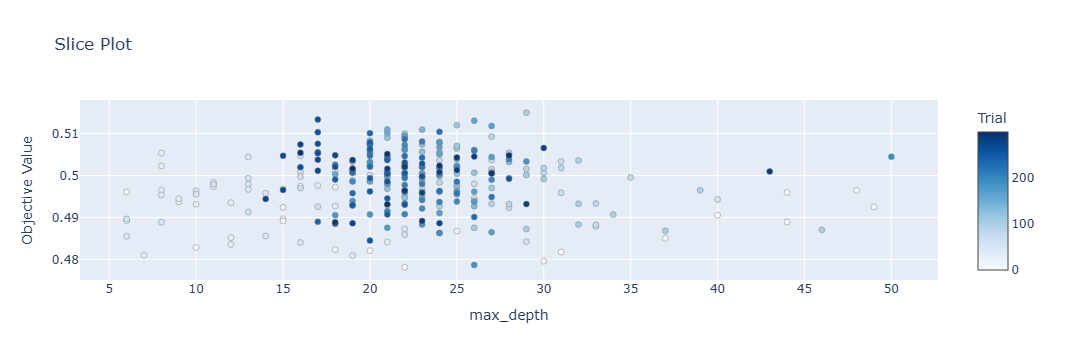

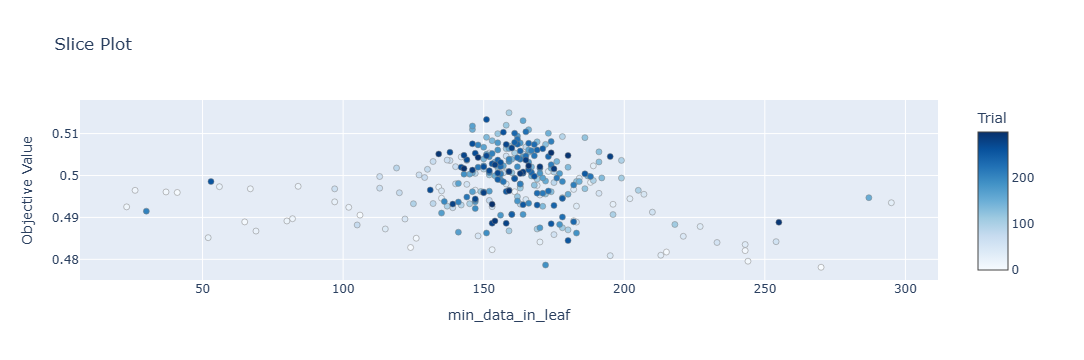

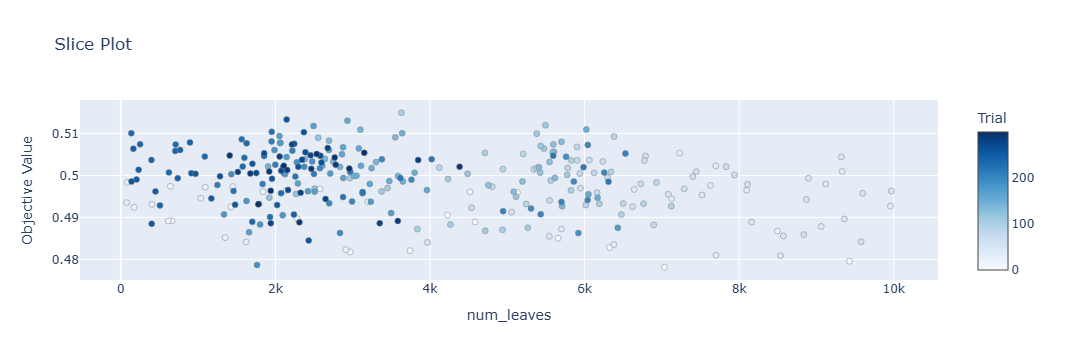

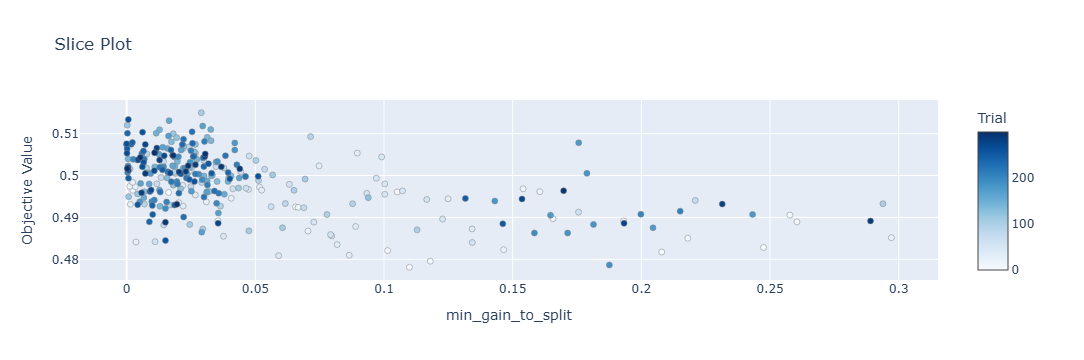

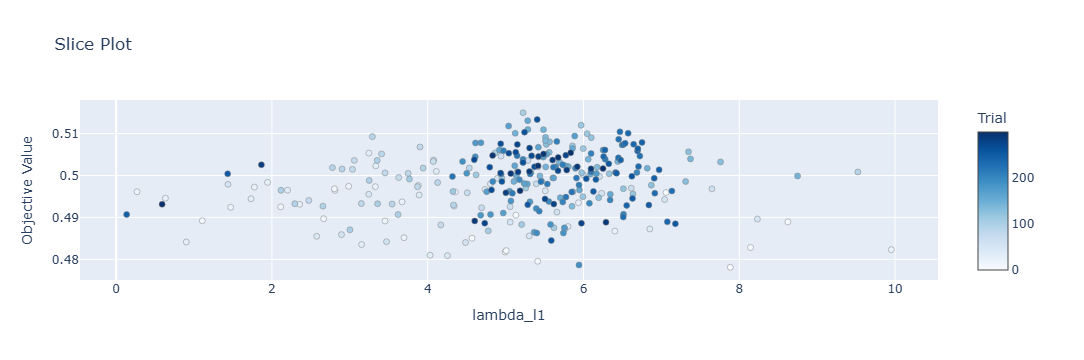

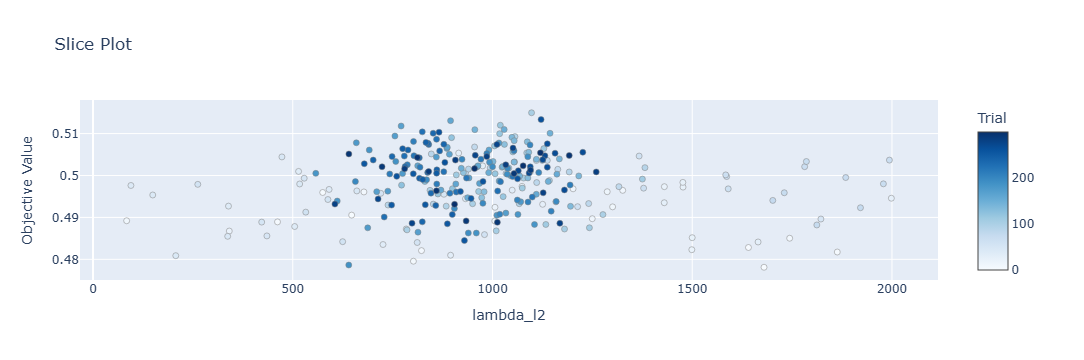

In [85]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

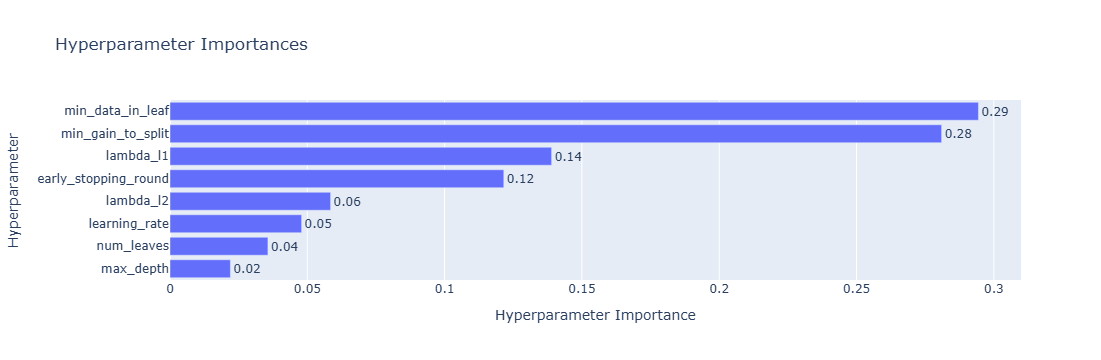

In [86]:
plot_param_importances(lgb_optuna_study)

In [87]:
lgb_optuna_study.best_params

{'learning_rate': 0.24507524547524703,
 'early_stopping_round': 59,
 'max_depth': 29,
 'min_data_in_leaf': 159,
 'num_leaves': 3631,
 'min_gain_to_split': 0.02900945641558242,
 'lambda_l1': 5.225476403310468,
 'lambda_l2': 1097.7924381751955}

In [88]:
cols = train_selected_df.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list2:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [89]:
train_selected_df3 = train_selected_df.drop(unimportant_cols, axis=1)
print(train_selected_df3.shape)
train_selected_df3.head()

(2736, 120)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          32.0                73.0                 102.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18          7.0         6.0   
1         3.0         23.08        24.94         11.0         3.0   
2        20.0         10.20        14.70         10.0         5.0   
3        18.0         17.66        19.24          7.0         7.0   
4        12.0         16.50        17.90         10.0         8.0   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     4.330360      16.68770             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  enmo_std  anglez_max  \
0                                     3.0  0.091819   89.296684   
1                                     0.0  0.120810   89.456932   
2                                     2.0  0.142927   89.528796   
3                                     0.0  0.106351   89.751656   
4                                     0.0  0.040610   89.476036   

   X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  Y_weekday_7_1%  \
0        -1.181594          0.029699         1.078925       -0.851288   
1        -1.175764          0.030971         1.245570       -0.980870   
2        -1.384442          0.013404         1.400885       -0.978399   
3        -0.973490         -0.213124         1.007214       -0.962770   
4        -1.015088          0.255062         1.005606       -0.877587   

   Y_weekday_7_entropy  Z_weekday_1_min  Z_weekday_2_90%  Z_weekday_3_std  \
0            24.108867        -1.001339         0.796212         0.544952   
1            20.828965        -1.000690         0.861982         0.592790   
2            64.399943        -1.001535         0.545133         0.548045   
3            42.000340        -1.013281         0.717635         0.554800   
4            21.477032        -1.011558         0.829801         0.635620   

   Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  enmo_weekday_3_mean  \
0         0.502684         -0.050002         0.546032             0.046002   
1         0.540959         -0.201450         0.483489             0.043606   
2         0.508000         -0.070163         0.535905             0.046373   
3         0.581047         -0.316070         0.644435             0.047503   
4         0.636366          0.148574         0.646251             0.010586   

   enmo_weekday_6_max  light_weekday_4_mean  light_weekday_4_max  \
0            2.353769             14.557556           929.050000   
1            2.285202             21.486544          1148.777557   
2            3.491380             40.495487          2174.520020   
3            0.882914             25.983143          2318.199951   
4            1.740874             52.696568          2578.000000   

   battery_use_since_wear_weekday_2_30%  \
0  

In [90]:
test_selected_df3 = test_selected_df.drop(unimportant_cols, axis=1)
print(test_selected_df3.shape)
test_selected_df3.head()

(20, 119)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Waist_Circumference  Physical-HeartRate  Physical-Systolic_BP  \
0                          25.0                80.0                 130.2   
1                          22.0                70.0                 122.0   
2                          27.0                94.0                 117.0   
3                          26.4                97.0                 117.0   
4                          31.7                75.4                 113.6   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_SRL  FGC-FGC_TL  \
0         0.0         20.50        21.18          7.0         6.0   
1         3.0         23.08        24.94         11.0         3.0   
2        20.0         10.20        14.70         10.0         5.0   
3        18.0         17.66        19.24          7.0         7.0   
4         5.8         28.28        27.96         12.5         8.6   

   BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0     2.668550      13.81770             2.6342               41.6   
1     2.579490      12.82540             2.3400               46.0   
2     4.310264      24.52766             2.1700               38.0   
3     3.841910      14.07400             2.4510               31.0   
4     5.477302      15.81610             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  enmo_std  anglez_max  \
0                                     3.0  0.091819   89.296684   
1                                     0.0  0.120810   89.456932   
2                                     2.0  0.142927   89.528796   
3                                     0.0  0.106351   89.751656   
4                                     2.2  0.095470   88.557333   

   X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  Y_weekday_7_1%  \
0        -1.181594          0.029699         1.078925       -0.851288   
1        -1.175764          0.030971         1.245570       -0.980870   
2        -1.384442          0.013404         1.400885       -0.978399   
3        -0.973490         -0.213124         1.007214       -0.962770   
4        -1.180735         -0.043651         0.682226       -0.716204   

   Y_weekday_7_entropy  Z_weekday_1_min  Z_weekday_2_90%  Z_weekday_3_std  \
0            24.108867        -1.001339         0.796212         0.544952   
1            20.828965        -1.000690         0.861982         0.592790   
2            64.399943        -1.001535         0.545133         0.548045   
3            42.000340        -1.013281         0.717635         0.554800   
4            31.479834        -0.601322         0.715061         0.555871   

   Z_weekday_5_std  Z_weekday_6_mean  Z_weekday_6_std  enmo_weekday_3_mean  \
0         0.502684         -0.050002         0.546032             0.046002   
1         0.540959         -0.201450         0.483489             0.043606   
2         0.508000         -0.070163         0.535905             0.046373   
3         0.581047         -0.316070         0.644435             0.047503   
4         0.363256         -0.016320         0.438409             0.059423   

   enmo_weekday_6_max  light_weekday_4_mean  light_weekday_4_max  \
0            2.353769             14.557556           929.050000   
1            2.285202             21.486544          1148.777557   
2            3.491380             40.495487          2174.520020   
3            0.882914             25.983143          2318.199951   
4            1.212740             15.765221          1052.849274   

   battery_use_since_wear_weekday_2_30%  \
0  

In [91]:
selected_cols = test_selected_df3.columns.tolist()
selected_cols_df = pd.DataFrame({'col':selected_cols})
selected_cols_df.to_csv(path + 'selected_cols.csv', index=False)

In [ ]:
lgb_models_list3, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df3, test_selected_df3, 200
)

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
cols = train_selected_df3.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list3:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df4 = train_selected_df3.drop(unimportant_cols, axis=1)
print(train_selected_df4.shape)
train_selected_df4.head()

In [ ]:
test_selected_df4 = test_selected_df3.drop(unimportant_cols, axis=1)
print(test_selected_df4.shape)
test_selected_df4.head()

In [ ]:
lgb_models_list4, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df4, test_selected_df4, 250
)

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
cols = train_selected_df4.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list4:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df5 = train_selected_df4.drop(unimportant_cols, axis=1)
print(train_selected_df5.shape)
train_selected_df5.head()

In [ ]:
test_selected_df5 = test_selected_df4.drop(unimportant_cols, axis=1)
print(test_selected_df5.shape)
test_selected_df5.head()

In [ ]:
lgb_models_list5, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df5, test_selected_df5, 300
)

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
cols = train_selected_df5.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list5:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df6 = train_selected_df5.drop(unimportant_cols, axis=1)
print(train_selected_df6.shape)
train_selected_df6.head()

In [ ]:
test_selected_df6 = test_selected_df5.drop(unimportant_cols, axis=1)
print(test_selected_df6.shape)
test_selected_df6.head()

In [ ]:
lgb_models_list6, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df6, test_selected_df6, 350
)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
cols = train_selected_df6.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list6:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df7 = train_selected_df6.drop(unimportant_cols, axis=1)
print(train_selected_df7.shape)
train_selected_df7.head()

In [ ]:
test_selected_df7 = test_selected_df6.drop(unimportant_cols, axis=1)
print(test_selected_df7.shape)
test_selected_df7.head()

In [ ]:
lgb_models_list7, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df7, test_selected_df7, 300
)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
cols = train_selected_df7.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list7:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df8 = train_selected_df7.drop(unimportant_cols, axis=1)
print(train_selected_df8.shape)
train_selected_df8.head()

In [ ]:
test_selected_df8 = test_selected_df7.drop(unimportant_cols, axis=1)
print(test_selected_df8.shape)
test_selected_df8.head()

In [ ]:
selected_cols = test_selected_df8.columns.tolist()
selected_cols_df = pd.DataFrame({'col':selected_cols})
selected_cols_df.to_csv(path + 'selected_cols.csv', index=False)

In [ ]:
lgb_models_list8, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df8, test_selected_df8, 3
)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def lgb_train(params, train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
lgb_params = {
    'verbosity': -1,
    'seed': SEED,
    'learning_rate': 0.01,
    'num_iterations': 3000,
    'early_stopping_round': 10,
    'max_depth': 12,
    'min_data_in_leaf': 40,
    'num_leaves': 20,
    'min_gain_to_split': 0.05,
    'feature_fraction': 0.8,
    #'bagging_fraction': 0.784,
    #'bagging_freq': 4,
    'lambda_l1': 2,
    'lambda_l2': 50,
    'device': 'gpu'
}

lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds = lgb_train(lgb_params, train_final_df, test_final_df)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_feature_selection(train_data, test_data, optuna_n_trials=100):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'iterations': 3000,
        'random_seed': SEED,
        'verbose': 0,
        'task_type': 'GPU',
        'use_best_model': True,
        'boosting_type': 'Plain'
    }

    def objective(trial):
        
        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
            'depth': trial.suggest_int('depth', 6, 9),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 10, 70),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 40)
        }
    
        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
            model = CatBoostRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=(X_val, y_val))#, plot=True)
    
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
            train_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                      method='Nelder-Mead')
            assert train_KappaOPtimizer.success, "Train Optimization did not converge."
    
            train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
            train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)
    
            #print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")
    
            val_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                      method='Nelder-Mead')
            assert val_KappaOPtimizer.success, "Val Optimization did not converge."
    
            val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
            val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)
    
            #print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")
    
            train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
            train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)
    
            #print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")
    
            val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
            val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)
    
            #print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")
    
            rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
            rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        
    
            train_S.append(train_Kappa)
            test_S.append(val_Kappa)
            
            test_preds[:, fold] = model.predict(test_data)
            
            #print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
            #clear_output(wait=True)
    
            models_list.append(model)
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        tpm = test_preds.mean(axis=1)
        tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
        
        submission = pd.DataFrame({
            'id': test_data_copy['id'],
            'sii': tpTuned
        })
    
        return tKappa

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_n_trials)  # You can increase n_trials for better results

    return study

In [ ]:
catboost_optuna_study = catboost_feature_selection(train_final_df, test_final_df, 5)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_parallel_coordinate(catboost_optuna_study)

In [ ]:
plot_slice(catboost_optuna_study)

In [ ]:
plot_param_importances(catboost_optuna_study)

In [ ]:
plot_rank(catboost_optuna_study)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_train(train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    catboost_params = {
        'learning_rate': 0.02,
        'depth': 9,
        'iterations': 2000,
        'random_seed': SEED,
        'verbose': 0,
        'l2_leaf_reg': 15,
        'task_type': 'GPU',
        'use_best_model': True,
        'early_stopping_rounds': 30,
        'boosting_type': 'Ordered'
    }

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(
            **catboost_params
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
cat_models_list, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds = catboost_train(train_final_df, test_final_df)

In [ ]:
#submission_df.to_csv('submission.csv', index=False)